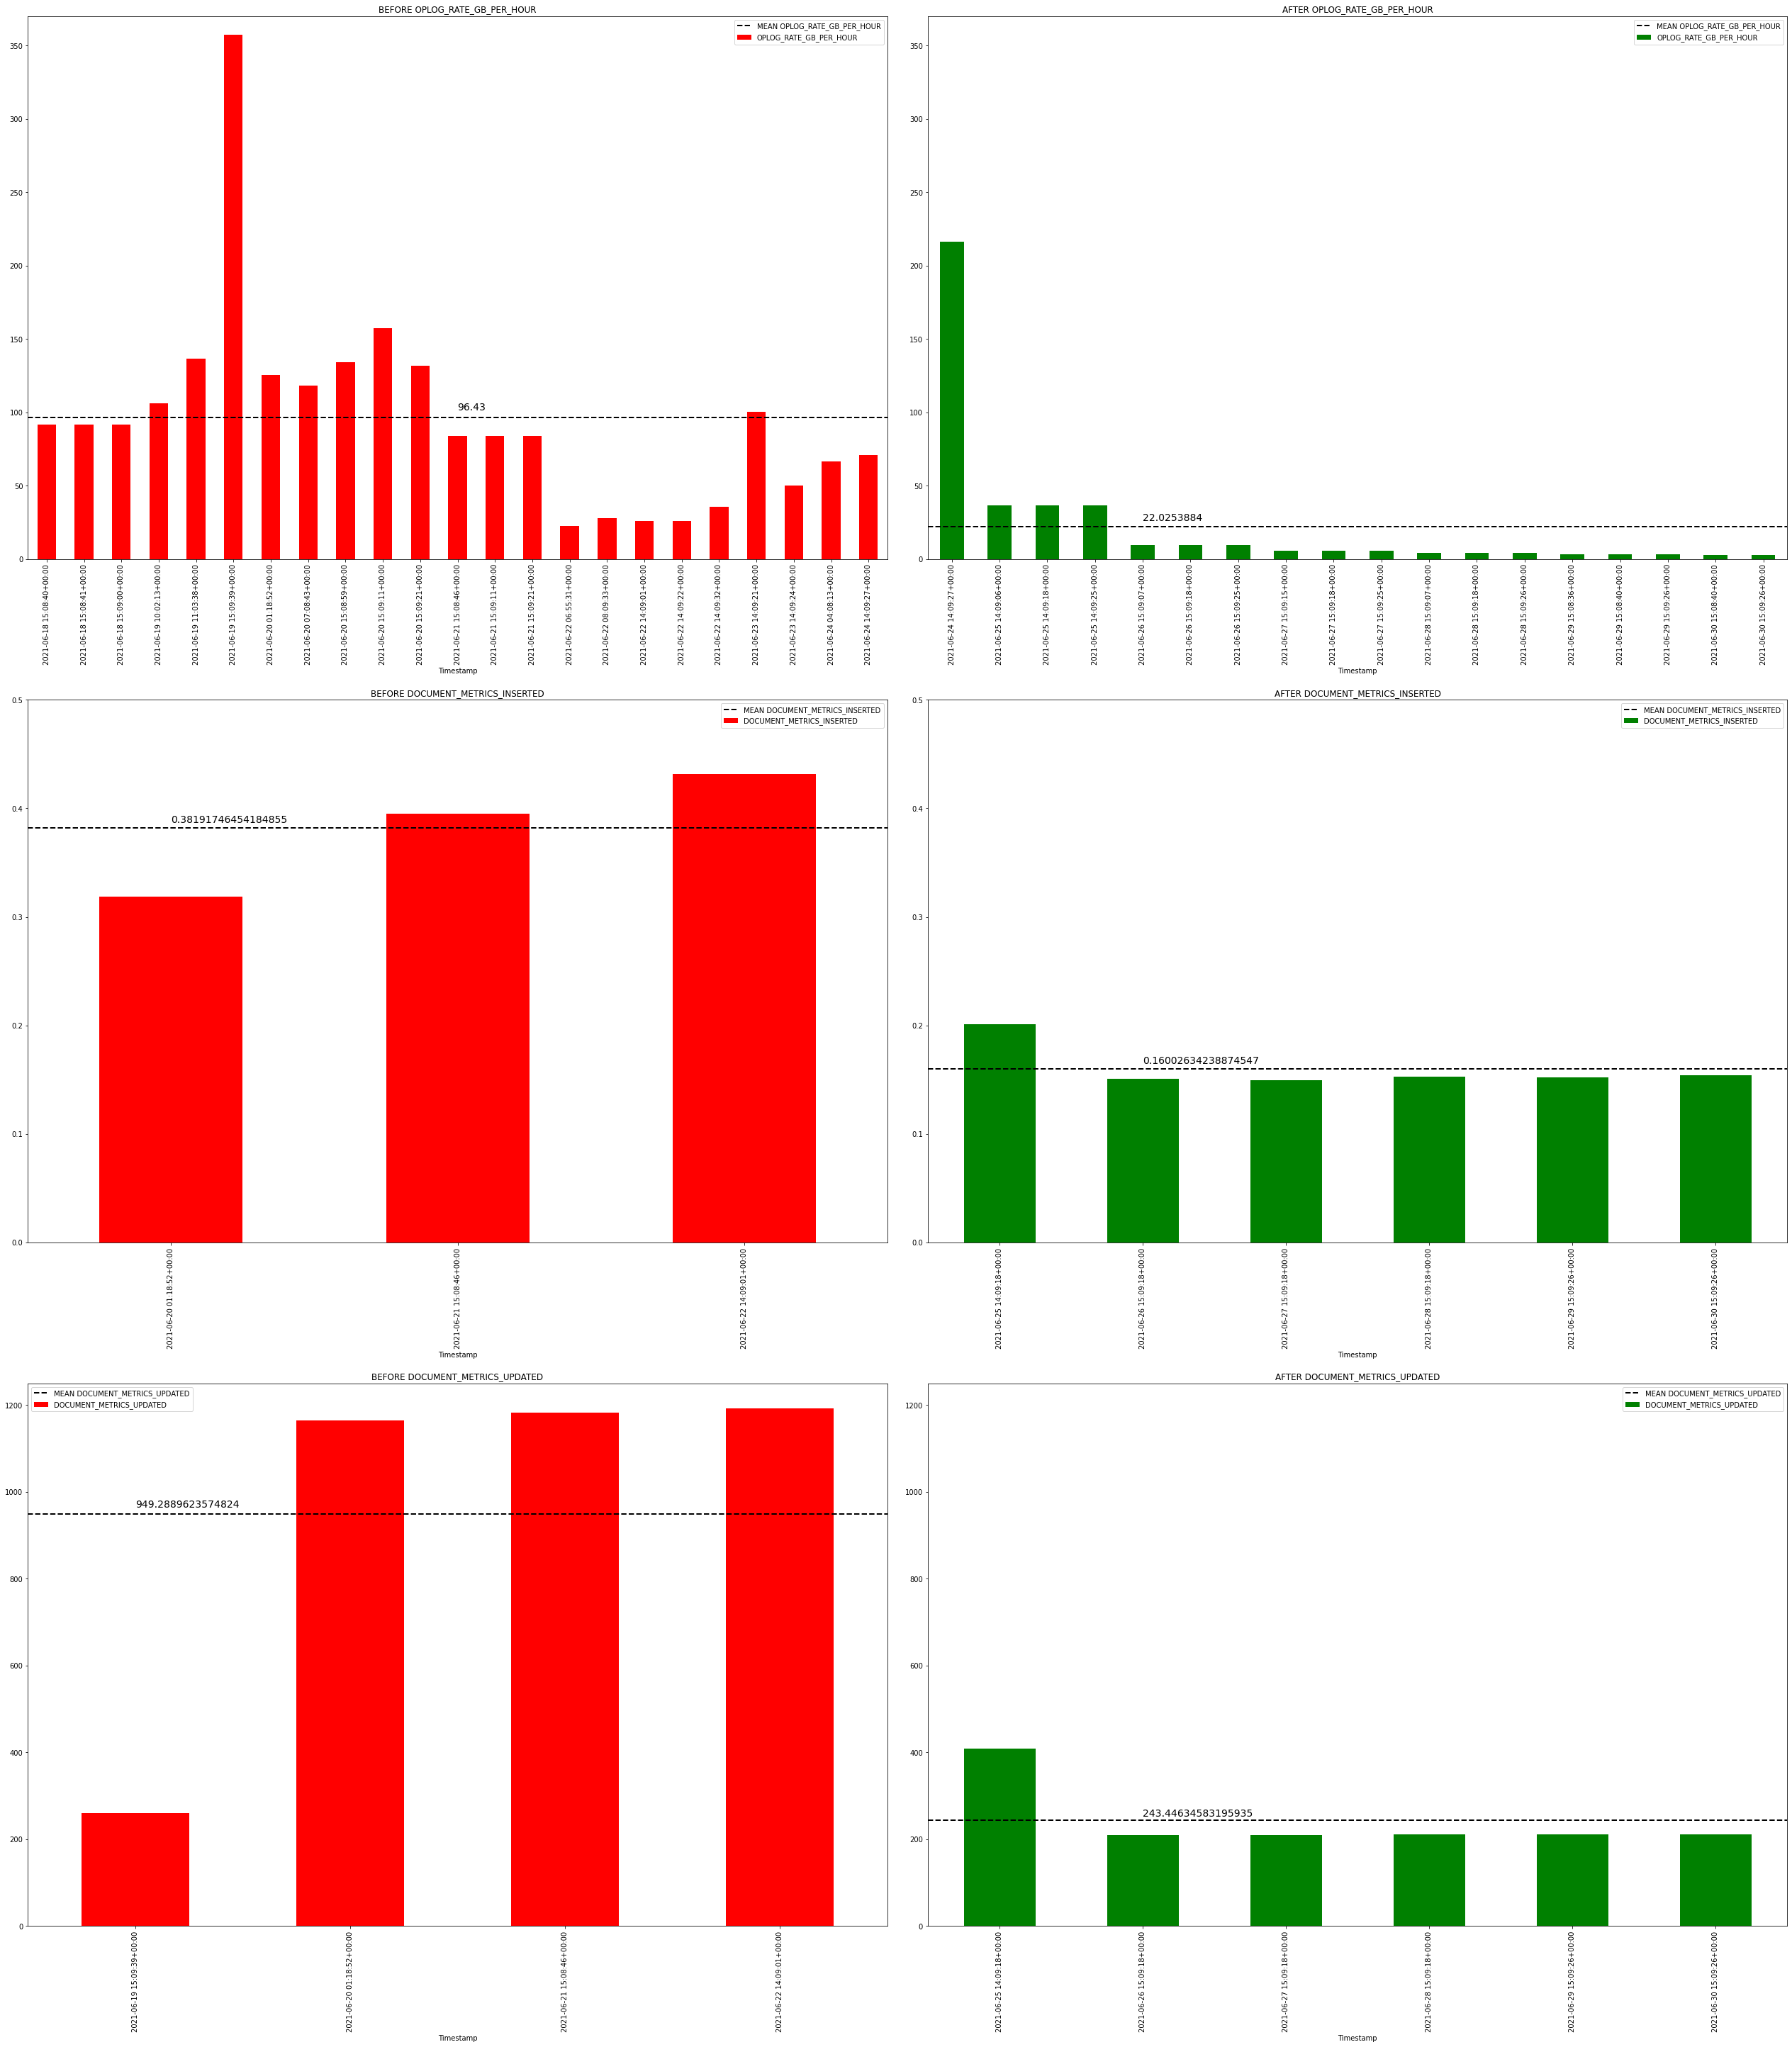

In [90]:
from conv import DataPoint, parse, Metrics, convertToMatrix, writeCsv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def buildDataFrame(metricFiles: list[str]) -> pd.DataFrame:
    dataFrames = []
    for i in range(len(metricFiles)):
        metrics: Metrics = parse(metricFiles[i])
        matrix = convertToMatrix(metrics)
        csvFile = f"tmp-{i}.csv" 
        writeCsv(csvFile, matrix)
        frame = pd.read_csv(csvFile, parse_dates = ['Timestamp'])
        frame = frame[['Timestamp', 'OPLOG_RATE_GB_PER_HOUR (GIGABYTES_PER_HOUR)', 'DOCUMENT_METRICS_INSERTED (SCALAR_PER_SECOND)', 'DOCUMENT_METRICS_UPDATED (SCALAR_PER_SECOND)']]
        frame = frame.rename(columns={'OPLOG_RATE_GB_PER_HOUR (GIGABYTES_PER_HOUR)': f'OPLOG_RATE_GB_PER_HOUR {i+1}', 'DOCUMENT_METRICS_INSERTED (SCALAR_PER_SECOND)': f'DOCUMENT_METRICS_INSERTED {i+1}', 'DOCUMENT_METRICS_UPDATED (SCALAR_PER_SECOND)': f'DOCUMENT_METRICS_UPDATED {i+1}' })
        dataFrames.append(frame)
    
    assert len(dataFrames) == len(metricFiles)
    dataFrame: pd.DataFrame = dataFrames[0].set_index("Timestamp")
    for i in range(len(dataFrames) - 1):
        dataFrame = dataFrame.join(dataFrames[i + 1].set_index('Timestamp'), on = 'Timestamp', how = 'outer')
    
    dataFrame = dataFrame.set_index('Timestamp').fillna(0)
    dataFrame['OPLOG_RATE_GB_PER_HOUR'] = dataFrame['OPLOG_RATE_GB_PER_HOUR 1']
    dataFrame['DOCUMENT_METRICS_INSERTED'] = dataFrame['DOCUMENT_METRICS_INSERTED 1']
    dataFrame['DOCUMENT_METRICS_UPDATED'] = dataFrame['DOCUMENT_METRICS_UPDATED 1']
    for i in range(1, len(dataFrames)):
        dataFrame['OPLOG_RATE_GB_PER_HOUR'] += dataFrame[f'OPLOG_RATE_GB_PER_HOUR {i+1}']
        dataFrame['DOCUMENT_METRICS_INSERTED'] = dataFrame[f'DOCUMENT_METRICS_INSERTED {i+1}']
        dataFrame['DOCUMENT_METRICS_UPDATED'] = dataFrame[f'DOCUMENT_METRICS_UPDATED {i+1}']

    return dataFrame[['OPLOG_RATE_GB_PER_HOUR', 'DOCUMENT_METRICS_INSERTED','DOCUMENT_METRICS_UPDATED']].sort_values(by = 'Timestamp')


before = buildDataFrame(['before-1.json', 'before-2.json', 'before-3.json'])
after = buildDataFrame(['after-1.json', 'after-2.json', 'after-3.json'])

fig, axs = plt.subplots(figsize = (35, 40), nrows=3, ncols=2, constrained_layout=True)

beforeOplog = before[before['OPLOG_RATE_GB_PER_HOUR'] != 0]['OPLOG_RATE_GB_PER_HOUR']
axs[0,0].axhline(beforeOplog.mean(), color = 'black', linestyle='dashed', linewidth=2, label = "MEAN OPLOG_RATE_GB_PER_HOUR")
axs[0,0].text(11, beforeOplog.mean() + 5, beforeOplog.mean().round(2), fontsize=14)
beforeOplog.plot(title = "BEFORE OPLOG_RATE_GB_PER_HOUR", color = "red", kind = 'bar', ax = axs[0, 0], ylim = (0, 370)).legend()

beforeInserted = before[before['DOCUMENT_METRICS_INSERTED'] != 0]['DOCUMENT_METRICS_INSERTED']
axs[1,0].axhline(beforeInserted.mean(), color = 'black', linestyle='dashed', linewidth=2, label = "MEAN DOCUMENT_METRICS_INSERTED")
axs[1,0].text(0, beforeInserted.mean() + 0.005, beforeInserted.mean().round(2), fontsize=14)
beforeInserted.plot(title = "BEFORE DOCUMENT_METRICS_INSERTED", color = "red", kind = 'bar', ax = axs[1, 0], ylim = (0, 0.5)).legend()

beforeUpdated = before[before['DOCUMENT_METRICS_UPDATED'] != 0]['DOCUMENT_METRICS_UPDATED']
axs[2,0].axhline(beforeUpdated.mean(), color = 'black', linestyle='dashed', linewidth=2, label = "MEAN DOCUMENT_METRICS_UPDATED")
axs[2,0].text(0, beforeUpdated.mean() + 15, beforeUpdated.mean().round(2), fontsize=14)
beforeUpdated.plot(title = "BEFORE DOCUMENT_METRICS_UPDATED", color = "red", kind = 'bar', ax = axs[2, 0], ylim = (0, 1250)).legend()

afterOpLog = after[after['OPLOG_RATE_GB_PER_HOUR'] != 0]['OPLOG_RATE_GB_PER_HOUR']
axs[0,1].axhline(afterOpLog.mean(), color = 'black', linestyle='dashed', linewidth=2, label = "MEAN OPLOG_RATE_GB_PER_HOUR")
axs[0,1].text(4, afterOpLog.mean() + 4, afterOpLog.mean().round(2), fontsize=14)
afterOpLog.plot(title = "AFTER OPLOG_RATE_GB_PER_HOUR", color = "green", kind = 'bar', ax = axs[0, 1], ylim = (0, 370)).legend()

afterInserted = after[after['DOCUMENT_METRICS_INSERTED'] != 0]['DOCUMENT_METRICS_INSERTED']
axs[1,1].axhline(afterInserted.mean(), color = 'black', linestyle='dashed', linewidth=2, label = "MEAN DOCUMENT_METRICS_INSERTED")
axs[1,1].text(1, afterInserted.mean() + 0.005, afterInserted.mean().round(2), fontsize=14)
afterInserted.plot(title = "AFTER DOCUMENT_METRICS_INSERTED", color = "green", kind = 'bar', ax = axs[1, 1], ylim = (0, 0.5)).legend()

afterUpdated = after[after['DOCUMENT_METRICS_UPDATED'] != 0]['DOCUMENT_METRICS_UPDATED']
axs[2,1].axhline(afterUpdated.mean(), color = 'black', linestyle='dashed', linewidth=2, label = "MEAN DOCUMENT_METRICS_UPDATED")
axs[2,1].text(1, afterUpdated.mean() + 10, afterUpdated.mean().round(2), fontsize=14)
afterUpdated.plot(title = "AFTER DOCUMENT_METRICS_UPDATED", color = "green", kind = 'bar', ax = axs[2, 1], ylim = (0, 1250)).legend()

